In [125]:
import pandas as pd
import numpy as np

In [126]:
df = pd.read_csv('train.csv')

In [127]:
df.drop(labels = ['textID','selected_text'] , axis = 1 , inplace = True)

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

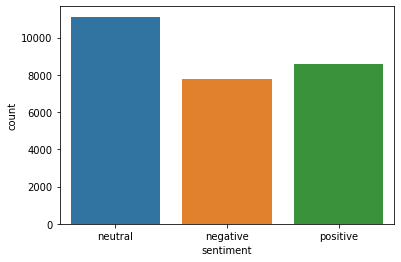

In [129]:
sns.countplot(x = 'sentiment' , data = df)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
text         27480 non-null object
sentiment    27481 non-null object
dtypes: object(2)
memory usage: 429.5+ KB


Here, 27840 text fields are there for 27841 entries. It means that there is 1 entry which has text field has NULL value. So we will drop that.

In [131]:
df.dropna(inplace = True)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
text         27480 non-null object
sentiment    27480 non-null object
dtypes: object(2)
memory usage: 644.1+ KB


Now, everything is balanced

In [133]:
#!pip install nltk
from nltk.corpus import stopwords
import nltk
import re
import string

In [134]:
#!pip install textblob

In [135]:
from textblob import TextBlob

In [136]:
df.reset_index(drop = True , inplace = True)
df.head(315)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
310,"Just opened a facebook account, I`m a little c...",positive
311,Ship. I`m stuck.,negative
312,DUSTBIN BABY ON AT 11.30 Cannot wait x,positive
313,"Not going to dwell on it. It happened, it`s p...",negative


Remove Punctuations using RegexpTokenizer, stopwords

In [202]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english" , ignore_stopwords = True)

def cleansing(df):
    text = []
    stop_words = set(stopwords.words('english'))
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    stem = nltk.stem.SnowballStemmer('english')

    for i in range(0, df.shape[0]):
        sentence = df['text'][i]
        sentence = tokenizer.tokenize(sentence)
        for x in sentence:
            x = stemmer.stem(x)
        sentence = [w for w in sentence if not w in stop_words]
        sentence = " ".join(sentence)
        sentence = sentence.lower()
        text.append(sentence)
    
    return text

from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer() # To make changes made to tfidf available outside the function

def tfidf_transform(text , max_features, want_vocab = False, vocab = False):
    if want_vocab == True:   # tfidf = vocab
        tfidf = TfidfVectorizer(max_features = max_features)
        text = tfidf.fit_transform(text)
        return tfidf , text
    else:
        unseen_data = vocab.transform(text)
        return unseen_data
        
text = cleansing(df)

In [139]:
"""from sklearn.feature_extraction.text import Vectorizer

vectorizer = HashingVectorizer(n_features = 1000)
text = vectorizer.fit_transform(text)"""

'from sklearn.feature_extraction.text import Vectorizer\n\nvectorizer = HashingVectorizer(n_features = 1000)\ntext = vectorizer.fit_transform(text)'

TF-IDF (Term frequency - Inverse Document Frequency): Normalizes the relevance of a word in the entire context of words. We use Scikit Learn's API for this

In [189]:
# Not required
from sklearn import preprocessing 

LabelEncoder = preprocessing.LabelEncoder()
y = LabelEncoder.fit_transform(df['sentiment'])
LabelEncoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [203]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text , LabelEncoder.fit_transform(df['sentiment']), 
                                                    test_size = 0.30, random_state = 42)

print('\nTraining Input Length : ' , len(X_train))
print('\nTesting Input Length : ' , len(y_train))
print('\nTraining Output Length : ' , len(X_test))
print('\nTesting Output Length : ' , len(y_test))

vocab , X_train = tfidf_transform(X_train , 1000 ,True)  # True only for training examples
X_test = tfidf_transform(X_test , 1000,False, vocab)


Training Input Length :  19236

Testing Input Length :  19236

Training Output Length :  8244

Testing Output Length :  8244


In [204]:
y_train

array([1, 0, 1, ..., 1, 2, 2])

In [25]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train.toarray() , y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
model.score(X_test.toarray() , y_test)

0.33624454148471616

In [50]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train.toarray() , y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [51]:
model.score(X_test.toarray() , y_test)

0.396045608927705

In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20 , random_state = 42)
model.fit(X_train ,  y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [67]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 600, num = 2)]
max_features = ['auto' , 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True , False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
}

In [68]:
random_grid

{'n_estimators': [200, 600],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [69]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                param_distributions = random_grid, n_iter = 10 , cv = 3, verbose = 2, 
                random_state = 42)

rf_random.fit(X_train , y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, total=  14.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, total=  14.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, total=  13.9s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=  27.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=  28.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_sam

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [71]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [74]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 2,
                    min_samples_leaf = 1, max_features = 'auto', max_depth = 90,
                               bootstrap = False, verbose = 2)
model.fit(X_train , y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   51.4s finished


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=90, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=2, warm_start=False)

In [75]:
model.score(X_test , y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished


0.3877971858321203

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = [
    {'multi_class': ['multinomial', 'ovr'],'solver': ['newton-cg'] , 
     'penalty': ['l2',], 'C': [1, 5, 10, 20, 50, 100],},
    {'multi_class': ['multinomial', 'ovr'],'solver': ['sag'], 'C':[1,5,10,20,30,50,100]}
]

grid_search = GridSearchCV(LogisticRegression(), param_grid , cv = 3, verbose = 2)
grid_search.fit(X_train , y_train)

Fitting 3 folds for each of 26 candidates, totalling 78 fits
[CV] C=1, multi_class=multinomial, penalty=l2, solver=newton-cg ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1, multi_class=multinomial, penalty=l2, solver=newton-cg, total=   0.9s
[CV] C=1, multi_class=multinomial, penalty=l2, solver=newton-cg ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  C=1, multi_class=multinomial, penalty=l2, solver=newton-cg, total=   0.9s
[CV] C=1, multi_class=multinomial, penalty=l2, solver=newton-cg ......
[CV]  C=1, multi_class=multinomial, penalty=l2, solver=newton-cg, total=   1.0s
[CV] C=1, multi_class=ovr, penalty=l2, solver=newton-cg ..............
[CV]  C=1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.9s
[CV] C=1, multi_class=ovr, penalty=l2, solver=newton-cg ..............
[CV]  C=1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.8s
[CV] C=1, multi_class=ovr, penalty=l2, solver=newton-cg ..............
[CV]  C=1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.7s
[CV] C=5, multi_class=multinomial, penalty=l2, solver=newton-cg ......
[CV]  C=5, multi_class=multinomial, penalty=l2, solver=newton-cg, total=   1.1s
[CV] C=5, multi_class=multinomial, penalty=l2, solver=newton-cg ......
[CV]  C=5, multi_class=multinomial, penalty=l2, solver=newton-cg, total=   1.2s
[CV] C=5, multi_class=multinomial, pen

[CV] ................ C=20, multi_class=ovr, solver=sag, total=   0.8s
[CV] C=20, multi_class=ovr, solver=sag ...............................
[CV] ................ C=20, multi_class=ovr, solver=sag, total=   0.6s
[CV] C=30, multi_class=multinomial, solver=sag .......................
[CV] ........ C=30, multi_class=multinomial, solver=sag, total=   1.0s
[CV] C=30, multi_class=multinomial, solver=sag .......................
[CV] ........ C=30, multi_class=multinomial, solver=sag, total=   0.8s
[CV] C=30, multi_class=multinomial, solver=sag .......................
[CV] ........ C=30, multi_class=multinomial, solver=sag, total=   0.8s
[CV] C=30, multi_class=ovr, solver=sag ...............................
[CV] ................ C=30, multi_class=ovr, solver=sag, total=   0.7s
[CV] C=30, multi_class=ovr, solver=sag ...............................
[CV] ................ C=30, multi_class=ovr, solver=sag, total=   1.0s
[CV] C=30, multi_class=ovr, solver=sag ...............................
[CV] .

/home/nisarg/ml/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, multi_class=multinomial, solver=sag, total=   1.1s
[CV] C=100, multi_class=multinomial, solver=sag ......................
[CV] ....... C=100, multi_class=multinomial, solver=sag, total=   1.0s
[CV] C=100, multi_class=multinomial, solver=sag ......................
[CV] ....... C=100, multi_class=multinomial, solver=sag, total=   0.9s
[CV] C=100, multi_class=ovr, solver=sag ..............................
[CV] ............... C=100, multi_class=ovr, solver=sag, total=   1.0s
[CV] C=100, multi_class=ovr, solver=sag ..............................
[CV] ............... C=100, multi_class=ovr, solver=sag, total=   1.1s
[CV] C=100, multi_class=ovr, solver=sag ..............................
[CV] ............... C=100, multi_class=ovr, solver=sag, total=   1.6s


[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 5, 10, 20, 50, 100],
                          'multi_class': ['multinomial', 'ovr'],
                          'penalty': ['l2'], 'solver': ['newton-cg']},
                         {'C': [1, 5, 10, 20, 30, 50, 100],
                          'multi_class': ['multinomial', 'ovr'],
                          

In [84]:
grid_search.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [143]:
model = grid_search.best_estimator_
model.fit(X_train , y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [144]:
model.score(X_test , y_test)

0.39313440077632217

In [ ]:
data = pd.read_csv('Lockdown1.csv')

In [ ]:
data.columns

In [208]:
stop_words = set(stopwords.words('english'))
tokenizer = nltk.RegexpTokenizer(r"\w+")
stem = nltk.stem.SnowballStemmer('english')

def predictor(model , sentence, vocab = False):
    assert vocab is not False
    sentence = tokenizer.tokenize(sentence)
    for x in sentence:
        x = stemmer.stem(x)
    sentence = [w for w in sentence if not w in stop_words]
    sentence = " ".join(sentence)
    sentence = sentence.lower()
    sentence = [sentence]
    sentence_encoded = tfidf_transform(sentence ,1000, False, vocab) 
    print(sentence_encoded)

    return model.predict(sentence_encoded)

In [234]:
predictor(model, "Corona has brought worst things out of people", vocab)

  (0, 971)	0.6754026984014836
  (0, 835)	0.5498626770971372
  (0, 636)	0.49140841601214386


array([0])

In [ ]:
predictor(model, "Corona has brought good things out of people", vocab)

In [213]:
LabelEncoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [237]:
data['tweet'][0]

'@AUThackeray Sir thank you so much for All your Care But some of us are still not following order of the time . My neighbours are treating this lockdown as vacation . There relatives staying in nearby areas are frequent visitors and till late night they have gala time .'

In [238]:
predictor(model, data['tweet'][0], vocab)

  (0, 895)	0.23771018857697213
  (0, 849)	0.36597098925251587
  (0, 848)	0.2590141558775331
  (0, 832)	0.2875265274975976
  (0, 826)	0.2334115661906725
  (0, 791)	0.19795237260028606
  (0, 790)	0.32056679296903495
  (0, 593)	0.19213159368284569
  (0, 578)	0.20271550268152602
  (0, 573)	0.19597886605478002
  (0, 470)	0.2578392902995261
  (0, 309)	0.2747492004582457
  (0, 138)	0.2962466946488736
  (0, 125)	0.2210392760349154
  (0, 30)	0.26146809716418146


array([1])

In [182]:
pd.Series(y_train).value_counts()

1    7774
2    6037
0    5425
dtype: int64

In [167]:
model.predict(X_train.toarray()[4:90])

array([0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 2, 1, 1, 1, 2, 0, 1, 2, 1, 0, 2, 1,
       1, 1, 1, 2, 1, 0, 1, 0, 1, 2, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 1,
       0, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 0, 2, 0, 1, 2, 1,
       2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 1, 1, 1, 2, 2, 2])

In [166]:
y_train[4:90]

array([0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 2, 1, 1, 1, 2, 0, 1, 2, 1, 0, 2, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 2, 2, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 1,
       1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 0, 0, 2, 2,
       2, 0, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 1, 0, 1, 1, 1, 2, 1, 2])

In [156]:
st = "Hello word"
predictor(model, st)
#predictor(model,"".join(list(st)))

(1, 2)


In [ ]:
st = "hello"
print(["".join(list(st))])

In [93]:
import tensorflow as tf
from tensorflow import keras

In [103]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(20, activation = 'relu'),
    keras.layers.Dense(17, activation = 'softmax'),
    keras.layers.Dense(3, activation = 'softmax'),
])

In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 30)                30030     
_________________________________________________________________
dense_8 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_9 (Dense)              (None, 17)                357       
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 54        
Total params: 31,061
Trainable params: 31,061
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(X_train.toarray(), LabelEncoder.fit_transform(y_train) , epochs = 10)

Train on 19236 samples
Epoch 1/10
19236/19236 [==============================] - 12s 642us/sample - loss: 0.9614 - accuracy: 0.5401
Epoch 2/10
19236/19236 [==============================] - 4s 198us/sample - loss: 0.7719 - accuracy: 0.7009
Epoch 3/10
19236/19236 [==============================] - 4s 200us/sample - loss: 0.7249 - accuracy: 0.7187
Epoch 4/10
19236/19236 [==============================] - 4s 208us/sample - loss: 0.7037 - accuracy: 0.7298
Epoch 5/10
19236/19236 [==============================] - 4s 205us/sample - loss: 0.6869 - accuracy: 0.7380
Epoch 6/10
19236/19236 [==============================] - 4s 204us/sample - loss: 0.6754 - accuracy: 0.7458
Epoch 7/10
19236/19236 [==============================] - 4s 204us/sample - loss: 0.6631 - accuracy: 0.7514
Epoch 8/10
19236/19236 [==============================] - 4s 219us/sample - loss: 0.6494 - accuracy: 0.7597
Epoch 9/10
19236/19236 [==============================] - 4s 208us/sample - loss: 0.6352 - accuracy: 0.7670
Epoc

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
history = model.fit(X_train.toarray(), LabelEncoder.fit_transform(y_train) , epochs = 10)

In [108]:
model.evaluate(X_test.toarray() , y_test)

8244/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.5148784165125573, 0.3898593]